In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

from src.SMT_Analysis_BP.databases.trajectory_analysis_script import *
import os
import numpy as np
from src.SMT_Analysis_BP.helpers.MSD_Utils import *
from src.SMT_Analysis_BP.helpers.plotting_functions import *
from src.SMT_Analysis_BP.helpers.import_functions import *
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.diff_mw import *
from src.SMT_Analysis_BP.Random.scalebars import *
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from src.SMT_Analysis_BP.helpers.guassian_fit import gaussian2D_residual,SM_localization_movie
from src.SMT_Analysis_BP.Parameter_Store.global_params import *
from src.SMT_Analysis_BP.databases.data_path_container import rpoc
from skimage.io import imread

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_67014/3848245550.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
#util functions
def identify_points(paths):

    params = {'cen_x':0,'cen_y':0,'sig_x':1,'sig_y':1,'offset':0,'height':1}
    param_bound = {'cen_x':(0,np.inf),'cen_y':(0,np.inf),'sig_x':(0,np.inf),'sig_y':(0,np.inf),'offset':(0,np.inf),'height':(0,np.inf)}
    prune_conditions = {'sig_x':(1.5,3.5),'sig_y':(1.5,3.5)}
    model = gaussian2D_residual
    for i in paths:
        #make a directory to save the results in this directory
        save_path = os.path.join(os.path.dirname(i),'Point_Results')
        for j in glob.glob(i+'/*.tif'):
            print("Working on {}".format(j))
            #initialize the SM_Localization_movie class
            image = imread(j)
            sm_localization_movie = SM_localization_movie(image)
            _ = sm_localization_movie.fit(model,params,param_bound,prune_conditions)
            sm_localization_movie._save_dataframe(os.path.join(save_path,os.path.basename(j).split('.tif')[0]+'.csv'))
            print("Done with {}, saved to {}".format(i,save_path))
    return



In [4]:
  
identify_points(["/Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies"])


Working on /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies/Photobleaching_LL_EZ_fixed_1.tif
Time to fit frame: 71.2703959941864 seconds
Time to convert fit results to pandas dataframe: 7.3996052742004395 seconds
Done with /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies, saved to /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Point_Results
Working on /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies/Photobleaching_LL_EZ_fixed_13.tif
Time to fit frame: 65.20320010185242 seconds
Time to convert fit results to pandas dataframe: 6.297351837158203 seconds
Done with /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies, saved to /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Point_Results
Working on /Volumes/Baljyot_HD/20231002/photobleaching_lacI_laco_fixed_1p_PFA/Movies/Photobleaching_LL_EZ_fixed_17.tif
Time to fit frame: 65.3695170879364 seconds
Time to co

In [49]:
point_paths = {
    "rpoc_ez_loc":["/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/RPOC_DATA/EZ_120min/20190527/rpoc_ez/Point_Results",
                   "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/RPOC_DATA/EZ_120min/20180813/Other_RPOC/Point_Results",
                   "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/RPOC_DATA/EZ_120min/20181003/RPOC_new/Point_Results"],
    "ll_ez_loc":["/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/LacI_LacO_DATA/EZ_120min/20190527/ll_ez/Point_Results",
                 "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/LacI_LacO_DATA/EZ_120min/20200217/ll_ez/Point_Results",
                 "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/LacI_LacO_DATA/EZ_120min/20200217/ll_ez_2/Point_Results"]
}
#utility function to read and plot the # of photons and loc_error
def theoretical_photons_loc_error(path,photon_conversion_factor,quantum_efficiency,dark_offset,pixel_size,psf_sigma,name):
    if isinstance(path,str):
        loc = glob.glob(path+'/*.csv')
        loc.sort()
    if isinstance(path,list):
        loc_global = []
        for i in path:
            loc = glob.glob(i+'/*.csv')
            loc.sort()
            loc_global.append(loc)
        loc = np.concatenate(loc_global)
    #from each of the .csv files load the data into a collective dataframe using concat
    loc_df = pd.DataFrame()
    for i in loc:
        loc_df = pd.concat([loc_df,pd.read_csv(i)])
    loc_df.reset_index(drop=True,inplace=True)

    #get the heights and the loc_error
    heights = (loc_df['height'].values)*loc_df['sig_x'].values*loc_df['sig_y'].values*2*np.pi
    #convert the height values to # of photons using the photon conversion factor function in analysis functions
    photons_loc = photon_conversion_from_AUD(AUD=heights,
                                            photon_conversion_factor=photon_conversion_factor,
                                            quantum_efficiency=quantum_efficiency,
                                            dark_offset=0)
    background_photons = photon_conversion_from_AUD(AUD=abs((loc_df["Image_Background_Std"].values))*loc_df['sig_x'].values*loc_df['sig_y'].values,
                                                    photon_conversion_factor=photon_conversion_factor,
                                                    quantum_efficiency=quantum_efficiency,
                                                    dark_offset=0)
    print("Mean # of Photons: {:.2f} +/- {:.2f}".format(np.mean(photons_loc),np.std(photons_loc)))
    print("Mean Background Photons: {:.2f} +/- {:.2f}".format(np.mean(background_photons),np.std(background_photons)))
    #using the photons find the Thompson localization error
    loc_error = Thompson_localization_precision(pixel_size=pixel_size,psf_sigma=psf_sigma,num_photons=photons_loc,background_photons=background_photons)

    #make a new figure 
    fig = plt.figure(figsize=(12,5))
    gs = fig.add_gridspec(1,2)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    #plot the # of photons on the first axis
    ax1.hist(photons_loc,bins=int(np.sqrt(len(photons_loc))),weights=np.ones_like(photons_loc)/len(photons_loc),label = "# of Photons: {:.2f} +/- {:.2f} \n N = {}".format(np.mean(photons_loc),np.std(photons_loc),len(photons_loc)))
    ax1.set_xlabel("Photons per Localization")
    ax1.set_ylabel("Frequency")
    # ax1.set_title("Peak Photons per Localization")
    #plot the loc_error on the second axis
    ax2.hist(loc_error,bins=int(np.sqrt(len(loc_error))),weights=np.ones_like(loc_error)/len(loc_error),label = "$\sigma$: {:.2f} +/- {:.2f} \n N = {}".format(np.mean(loc_error),np.std(loc_error),len(loc_error)))
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("Localization Error (nm)")
    # ax2.set_title("Localization Error")
    #supertitle
    fig.suptitle("Theoretical Localization Error using # of Photons \n Collected per Localization for: {}".format(name))
    plt.show()



Mean # of Photons: 833.51 +/- 462.64
Mean Background Photons: 13.22 +/- 7.23


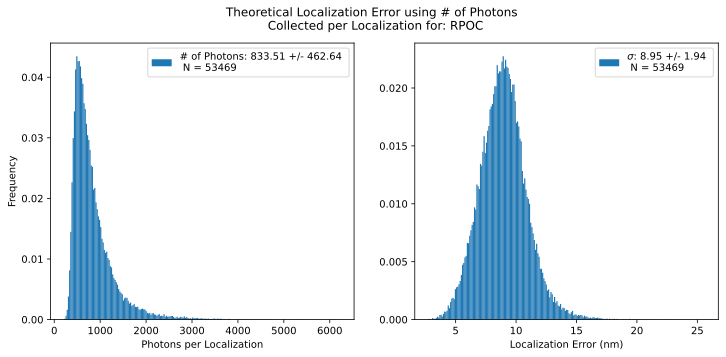

In [58]:
theoretical_photons_loc_error(point_paths['rpoc_ez_loc'],
                              PHOTON_CONVERSION_FACTORS["olympus_sCMOS_old"],
                              QUANTUM_EFFICIENCY_561["olympus_sCMOS_old"],
                              dark_offset=100,
                              pixel_size=PIXELSIZES["olympus_pixel_size"],
                              psf_sigma=146,
                              name = "RPOC")

Mean # of Photons: 647.32 +/- 268.22
Mean Background Photons: 7.17 +/- 1.79


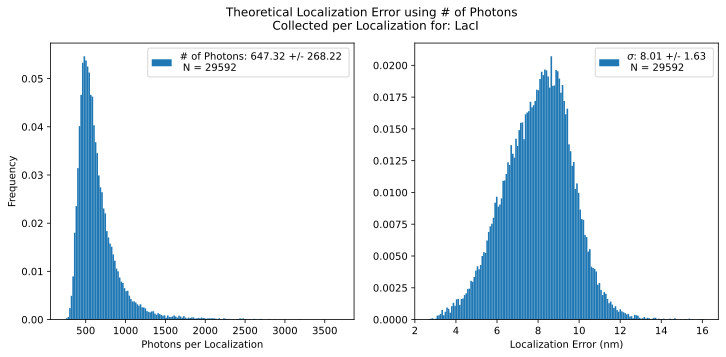

In [55]:
theoretical_photons_loc_error(point_paths['ll_ez_loc'],
                              PHOTON_CONVERSION_FACTORS["olympus_sCMOS_old"],
                              QUANTUM_EFFICIENCY_561["olympus_sCMOS_old"],
                              dark_offset=100,
                              pixel_size=PIXELSIZES["olympus_pixel_size"],
                              psf_sigma=146,
                              name = "LacI")